## Предсказание запаса реактивности на основе изотопных составов топливных зон

In [1]:
# Импоортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR, SVR
import tensorflow as tf

In [2]:
# Считываем подготовленный csv
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [3]:
#Посмотрим на кол-во объектов и признаков
main_df.shape

(91, 172802)

Итого 91 различный вариант, помиотрим хватит ли такого кол-ва

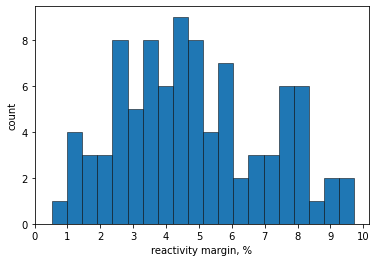

In [214]:
# Построим разброс значений целевой переменной
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

В целом явно выпадающих значений нет, большая часть значений лежит от 3 до 5%, что соответствуеют типичному циклу работы реактора

In [215]:
# Поскольку реактивность зависит только от Кэф, удаляем данный столбец
main_df.drop(columns=['Keff'], inplace=True)
target = main_df.pop('reactivity_margin')
# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)
# Проверяем раззмерности обуч. и тест. наборов
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

## Sklearn модели

In [4]:
# Для начала протестируем самую простую модель наименьших квадратов, а также три модели посложнее, линейную модель,
# которая минимизирует лосс с помощью стохастического градиентного спуска, линейную модель опорных векторов и модель опорных
# векторов с ядерным трюком. Для более сложных моделей будем подбирать оптимальный параметры с помощью HalvingGridSearch
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0005],
    'max_iter':[50000]
}

lin_svr = LinearSVR()
             
lin_svr_params = {
    'tol':[0.0005],
    'C':[0.1, 0.5, 1, 10],
    'max_iter':[50000]
}

svr = SVR()

svr_params = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005], 
    'C': np.logspace(-3,2, 6),
    'max_iter': [-1]
}


In [5]:
# Поскольку решается задача регрессии, то для поиска параметров можно ограничиться обычной k-блочной перекрестной проверкой
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [218]:
%%time 
# Обучаем модели
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=7,
                                     n_jobs=-1).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)


Wall time: 4min 29s


In [219]:
#Глядя на ошибку обычной линейной модели, можно сделать вывод, что данная модель для решения задачи не подходит
mean_absolute_error(y_test, lr.predict(X_test))

494.363415440665

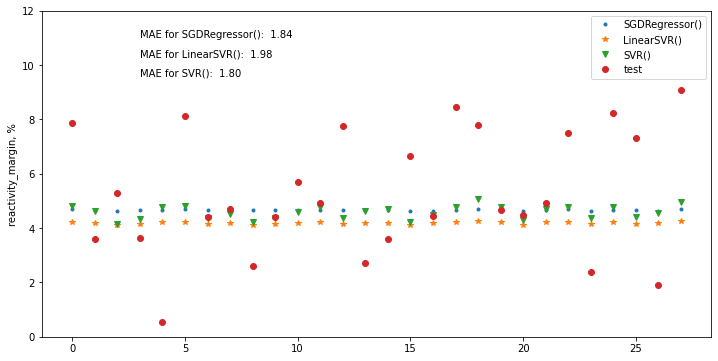

In [220]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test, y_pred): .2f}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test))], y_test, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Регрессионные модели способны предсказывать с довольно большой погрешностью, что может быть связано с влиянием различных ампульных устройств в отражателе, в особоенности ампулы в ячейке 6-4

In [2]:
# в файле final_with_ampules.csv помимо изотопных составов также имеется информация о ампуле в ячейке 6-4, которая
# уменьшает запас реактивности на порядка 2%. Это можно учесть просто вычев или прибавив данное значение, но 
# для начала можно попробовать учесть это простой индекацией наличия данной ампулы.
main_df2 = pd.read_csv('final_with_ampules.csv', sep=',', index_col=0 )

In [3]:
#Посчитаем кол-во вариантов с ампулой и без и соответствующие запасы
main_df2.groupby('ampule').agg({'Keff':'count', 'reactivity_margin':'mean'})

,Keff,reactivity_margin
ampule,,
0,22,4.867830
1,68,4.929305


In [4]:
main_df2.drop(columns=['Keff'], inplace=True)
target2 = main_df2.pop('reactivity_margin')

In [5]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(main_df2, target2, test_size=0.2, random_state=7)

In [10]:
%%time
#В качестве первого шага применим аналогичные модели
sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=9,
                                     n_jobs=-1).fit(X_train2, y_train2)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

Wall time: 6min 24s


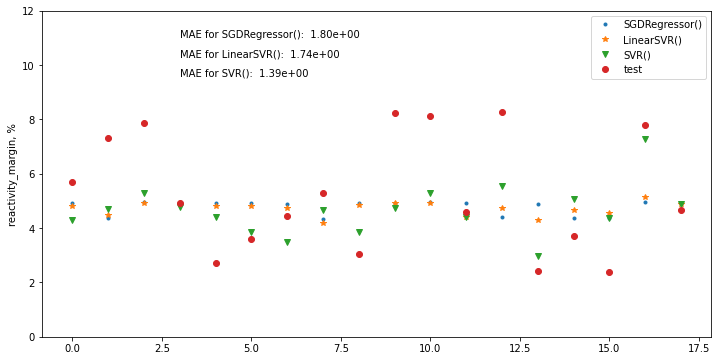

In [11]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test2)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test2, y_pred): .2e}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test2))], y_test2, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Добавив 1 признак наличия ампулы к уже имеющимся **172800**, удалось **снизить** абсолютную ошибку с **2** до **1.4** <div>
**Наилучшей** моделью из рассмотренных оказалась **SVC**, что связано с большой нелинейностью зависимости целевой переменной от признаков

## Библиотека XGBoost + Optuna

In [6]:
# !pip install xgboost
# !pip install optuna
import xgboost as xgb
import optuna

In [59]:
def objective(trial, data=maindf2, label=target2):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": "hist",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 8, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, pred_labels, squared=False)
    return rmse

In [60]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

NameError: name 'optuna' is not defined

In [58]:
mse = mean_squared_error([2,2,2], [4,4,4], squared=False)
mse

2.0

In [ ]:
%%time
xgb_reg = xgb.XGBRegressor()
xgb_reg_params = {
    'n_estimators':[450, 1000, 2000],
    'booster':['gblinear'],
    'max_depth': [2,4],
    'learning_rate':[0.0005, 0.0001, 0.00005],
    'eval_metric': ['rmse'],
     'verbosity':[2]
}

xgb_grid_search = GridSearchCV(estimator=xgb_reg, 
                               param_grid=xgb_reg_params,
                               scoring='neg_mean_squared_error',
                               cv=sss,
                               n_jobs=3).fit(X_train2, y_train2)